In [1]:
import os
import pickle

from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import graph_tool.all as gt
TURKEY_DIR = '/pool001/jschless/turkish_astroturfing'
follower_data_dir = os.path.join(TURKEY_DIR, 'follower_info')


# Build Follower Network

In [242]:
# Get unique users and make a dictionary mapping them to a unique number
df = pd.read_csv(os.path.join(TURKEY_DIR, 'trend_tweets.csv'))
uids = {k: v for v, k in enumerate(df.author_id.unique())}

In [35]:
# Build list of directed edges 
edges = []
for fi in os.listdir(follower_data_dir):
    user = uids.get(int(fi[:-4]), None)  
    if user is None:
        raise Exception(f"User id {fi[:-4]} not in dictionary")

    if os.path.getsize(os.path.join(follower_data_dir, fi)) > 0: # make sure file isn't empty
        with open(os.path.join(follower_data_dir, fi), 'rb') as f:
            followers = pickle.load(f)
            edges += [(uids[fol], user) for fol in followers if fol in uids]

In [36]:
# Build graph
g = gt.Graph(directed=True)
g.add_edge_list(edges)
g

# Load Tweet Information

In [2]:
df = pd.read_csv(os.path.join(TURKEY_DIR, 'trend_tweets.csv'),
                parse_dates=['date', 'trend_date', 'created_at'])
df.head()

,author_id,created_at,date,id,text,trend,trend_date,tweet_type
0,895667392533102592,2019-06-15 00:02:42,2019-06-15,1139684621174505474,RT @rbklndr: Türkiye Belediyeler Birliği Başka...,başarılar,2019-06-14,retweet
1,895667392533102592,2019-06-15 00:02:42,2019-06-15,1139684621174505474,RT @rbklndr: Türkiye Belediyeler Birliği Başka...,Türkiye Belediyeler Birliği,2019-06-13,retweet
2,18865007,2019-06-15 00:02:47,2019-06-15,1139684642137628672,... belki de en önemli sınavını verecek Tite'n...,#CopaAmerica,2019-06-15,tweet
3,18865007,2019-06-15 00:02:47,2019-06-15,1139684642137628672,... belki de en önemli sınavını verecek Tite'n...,#CopaAmerica,2019-06-14,tweet
4,2636562654,2019-06-15 00:03:29,2019-06-15,1139684818323591170,RT @kacsaatolduson: Rabia Naz için verilen ara...,Rabia Naz,2019-06-14,retweet


In [3]:
# convert to {hashtag => [tweets]}
campaigns = df.groupby("trend").apply(lambda x: x.to_dict(orient="records")).to_dict()

In [4]:
# get exposures
def is_following(child, parent):
    # returns true if child is following parent
    child_id = uids.get(child, None)
    parent_id = uids.get(parent, None)
    if child_id is None or parent_id is None:
        return False

    try: 
        return g.edge(child_id, parent_id) is not None
    except ValueError as e:
        print(e, 'probably missing follower information') 
        return False

exposures = {}
for ht, tweets in tqdm(campaigns.items()):
    ht_exposures = {}

    # sort tweets in reverse order 
    sorted_tweets = sorted(tweets, key=lambda x: x['date'])[::-1]
    for i in range(len(sorted_tweets)):
        n_exposures = 0
        child = sorted_tweets[i]
        for j in range(i, len(sorted_tweets)):
            # loop through all tweets that happened before
            potential_parent = sorted_tweets[j]
            if is_following(child['author_id'], potential_parent['author_id']):
                n_exposures += 1

        ht_exposures[child['author_id']] = n_exposures

    exposures[ht] = ht_exposures


  0%|          | 0/17160 [00:00<?, ?it/s]


NameError: name 'uids' is not defined

# Process Trending Information

In [7]:
trend_file = 'trend_analysis_top10.csv' 
#trend_file = 'world_trend_analysis_top10.csv'

trending_info = pd.read_csv(os.path.join(TURKEY_DIR, trend_file),
                           parse_dates=['tr_start', 'tr_end', 'lifetime', 'date'])

trending_info['trend'] = trending_info.keyword

trending_info = trending_info.drop(columns=['date', 'id', 'keyword'])

trending_info.head()

,tr_start,tr_end,vol,max_rank,lifetime,attack,trend
0,2019-06-27 06:14:01,2019-06-27 08:09:03,-1,8,0 days 01:55:02.000000000,False,"""Maçka"""
1,2019-06-20 18:38:28,2019-06-20 22:24:33,14474,1,0 days 03:46:05.000000000,True,#1200ÜcretliAtamasıHaktır
2,2019-06-20 22:29:29,2019-06-20 23:59:37,14495,6,0 days 01:30:08.000000000,False,#1200ücretliatamasıhaktır
3,2019-07-15 04:12:22,2019-07-15 13:02:52,118537,1,0 days 08:50:30.000000000,False,#15TEMMUZDESTANI
4,2019-07-15 13:32:57,2019-07-15 13:47:54,124473,1,0 days 00:14:57.000000000,False,#15TEMMUZDESTANI


In [8]:
import emoji
import string

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

def lexicon_classifier(line, trend):
    line = give_emoji_free_text(line)
    line = line.replace(trend, '')
    line = line.replace('  ', ' ')

    line = line.strip()

    if (len(line) == 0):
        return False

    if (line[0].isupper()):
        return False

    invalidChars = set(string.punctuation.replace("(", "…").replace(")", "...").replace('.', ".").replace('.', '.'))
    invalidChars = invalidChars.union(set(["%d" % i for i in range(0,10)])) # added numbers

    if any(char in invalidChars for char in line):
        return False

    tokens = line.split(' ')
    if (len(tokens) > 10 or len(tokens) < 3):
        return False



    return True

In [9]:
mega_df = df.merge(trending_info, on='trend')
mega_df["time_since_trending"] = mega_df.created_at - mega_df.tr_start
mega_df["time_since_trending"] = mega_df.time_since_trending.apply(lambda x: int(x.total_seconds() / 60))
mega_df["lexicon"] = mega_df.apply(lambda x: lexicon_classifier(x.text, x.trend), axis=1)


# Filtering
mega_df = mega_df[mega_df.attack == True] # only interested in attacked trends 
mega_df = mega_df.dropna()
mega_df.head()

,author_id,created_at,date,id,text,trend,trend_date,tweet_type,tr_start,tr_end,vol,max_rank,lifetime,attack,time_since_trending,lexicon
98373,622902679,2019-06-15 02:00:50,2019-06-15,1139522012223852544,RT @umutmurare: Trabzon’un yiğit evladı Şehit ...,#İyikiVarsınEren,2019-06-14,deletion,2019-07-02 20:44:22,2019-07-02 21:15:12,-1,1,0 days 00:30:50.000000000,True,-25603,False
98374,622902679,2019-06-15 02:00:50,2019-06-15,1139522012223852544,RT @umutmurare: Trabzon’un yiğit evladı Şehit ...,#İyikiVarsınEren,2019-06-14,deletion,2019-07-02 21:33:37,2019-07-02 21:48:40,-1,3,0 days 00:15:03.000000000,True,-25652,False
98375,622902679,2019-06-15 02:00:50,2019-06-15,1139522012223852544,RT @umutmurare: Trabzon’un yiğit evladı Şehit ...,#İyikiVarsınEren,2019-06-14,deletion,2019-07-02 21:58:30,2019-07-03 00:53:17,-1,3,0 days 02:54:47.000000000,True,-25677,False
98376,622902679,2019-06-15 02:00:50,2019-06-15,1139522012223852544,RT @umutmurare: Trabzon’un yiğit evladı Şehit ...,#İyikiVarsınEren,2019-06-15,deletion,2019-07-02 20:44:22,2019-07-02 21:15:12,-1,1,0 days 00:30:50.000000000,True,-25603,False
98377,622902679,2019-06-15 02:00:50,2019-06-15,1139522012223852544,RT @umutmurare: Trabzon’un yiğit evladı Şehit ...,#İyikiVarsınEren,2019-06-15,deletion,2019-07-02 21:33:37,2019-07-02 21:48:40,-1,3,0 days 00:15:03.000000000,True,-25652,False


In [10]:
astrobots = set(mega_df.query('lexicon == True').author_id.unique())

In [11]:
len(astrobots)

7260

In [12]:
pd.set_option('display.max_colwidth', None)

(array([1.3547e+04, 1.8770e+03, 6.1500e+02, 2.0600e+02, 6.3000e+01,
        2.5000e+01, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  1. ,  24.7,  48.4,  72.1,  95.8, 119.5, 143.2, 166.9, 190.6,
        214.3, 238. ]),
 <BarContainer object of 10 artists>)

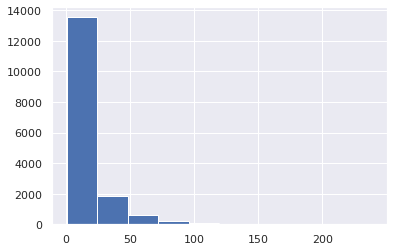

In [55]:
plt.hist(mega_df.query('time_since_trending < 0').groupby('author_id').count().id)

## Build timeseries

In [50]:
unique_authors = set()
def build_df(hashtag, tweet_dict, 
             include_missing=True, time_bin='5Min', minutes_to_round=5,
             drop_astrobots=True):
    for tweet in tweet_dict:
        # annotate whether we have follower information for user
        follower_file = os.path.join(follower_data_dir, str(tweet['author_id']) + '.txt') 
        tweet['follower_data'] = os.path.isfile(follower_file) and os.path.getsize(follower_file) > 0 
        
        # annotate number of exposures before posting
        tweet['n_exposures'] = 0 #exposures[hashtag][tweet['author_id']]

    df = pd.DataFrame.from_dict(tweet_dict)
    df.index = pd.to_datetime(df['created_at'])

    if not include_missing: 
        # Remove tweets from users lacking follower info
        df = df[df.follower_data == True]
        
    if drop_astrobots:
        df = df[~df.author_id.isin(astrobots)]
        

    trending_data = trending_info[trending_info.trend == hashtag]
    
    if len(trending_data) == 0: # hashtag never trended
        return 
    elif len(df) == 0: # trended but all tweets were removed because of missing follower data
        return
    elif trending_data.iloc[0].attack == False: # wasn't attacked
        return 

    start, end = trending_data.iloc[0].tr_start, trending_data.iloc[0].tr_end
    start = start - timedelta(minutes=start.minute % minutes_to_round,
                              seconds=start.second,
                              microseconds=start.microsecond)


    global unique_authors
    for a in df[df.tweet_type == "tweet"].author_id.unique():
        unique_authors.add(a)

    
    # Binning various statistics of interest
    series_list = []
    types = ['tweet', 'retweet', 'deletion']
    
    for t in types:
        temp = df[df.tweet_type == t] 
        temp = temp.resample(time_bin).count().author_id
        series_list.append(temp)
        
    temp = df[df.tweet_type == 'tweet']
    temp = temp[temp.n_exposures == 0].resample(time_bin).count().author_id
    
    
    series_list.append(temp)
    
    #return df, min_date, max_date
    
    new_df = pd.DataFrame(series_list).T
    new_df.columns = [*types, 'zero_exposure_tweets']
    
    # normalize time to minutes before / after trend
    new_df['absolute_time'] = new_df.index
    new_df.index = new_df.index - start
    new_df.index = new_df.index.map(lambda x: int(x.total_seconds() / 60))

    # add additional info to dataset
    new_df['trend'] = hashtag
    new_df['time'] = new_df.index
    new_df['time_i'] = range(len(new_df))
    new_df['trending_start'] = start

    return new_df

In [51]:
dfs = []
for trend, tweets in tqdm(campaigns.items()):
    if len(tweets) > 1000:
        temp_df = build_df(trend, tweets,
                          time_bin='5Min', minutes_to_round=5)

        if not temp_df is None:
            temp_df = temp_df.assign(threshold=(temp_df.time > 0).astype(int))
            dfs.append(temp_df)
panel_df = pd.concat(dfs)

100%|██████████| 17160/17160 [00:15<00:00, 1142.74it/s]


In [56]:
with open('authors.pkl', 'wb') as f:
    pickle.dump(unique_authors, f)

In [57]:
ls

a4.html
a4.js
a4_new.js
Advanced_Trending_Statistics.ipynb
Alternate_Attribution_Methods.ipynb
Analysis_of_Attribution_Models.ipynb
authors.pkl
build_cascades.py
campaign_cascades.pkl
Campaign_Characterization.ipynb
cascade.py
clustering.py
clustering.py~
Clustering_Tweets.ipynb
color-legend.js
colorlegend.js
config.py
d3-annotation.js
data/
Digraph.gv
Digraph.gv.pdf
encode_sentences.py
Exploration.ipynb
Exposure_Curves.ipynb
exposure_script.py
exposure_script.py~
exposure_script_rt_and_nt.py
follower_hydration.py
Follower_Network.ipynb
Hashtag_Cascades_Aggregate.ipynb
Hashtag_Cascades_Case_Study.ipynb
hashtags.py
hdbscan_script.py
imports.py
index.html
index.php
main.css
nearest_neighbors_revised.py
nearest_neighbors_script2.py
nearest_neighbors_script_local2.py
nearest_neighbors_script_local.py
nearest_neighbors_script.py
network_plots.py
new_network_exposures.py
normal_tweet_popularity_by_user_type.png
plots/
plotting.py
preprocessing.py
__pycache__/
README.md
RT_Cascades.ipynb
Sema

In [52]:
len(unique_authors)

7499

### Plotting

In [21]:
import trending, statsmodels.formula.api as smf

In [22]:
import seaborn as sns

sns.set(style="darkgrid")

No handles with labels found to put in legend.


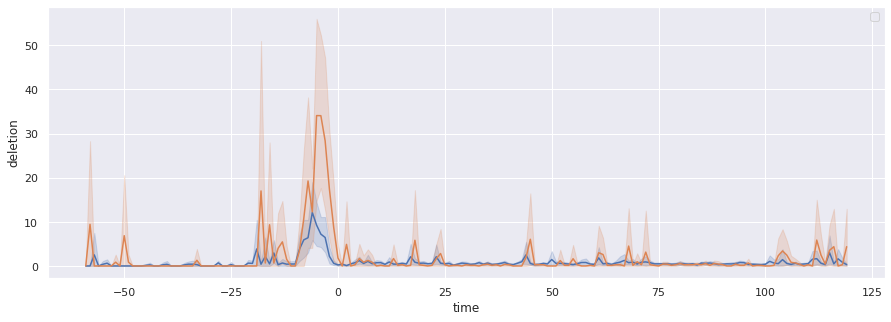

In [328]:
plt.figure(figsize=(15,5))
sns.lineplot(x="time", y="tweet",
             data=panel_df.loc[(panel_df.index>-60)&(panel_df.index<120)])
sns.lineplot(x="time", y="deletion",
             data=panel_df.loc[(panel_df.index>-60)&(panel_df.index<120)])

plt.legend()

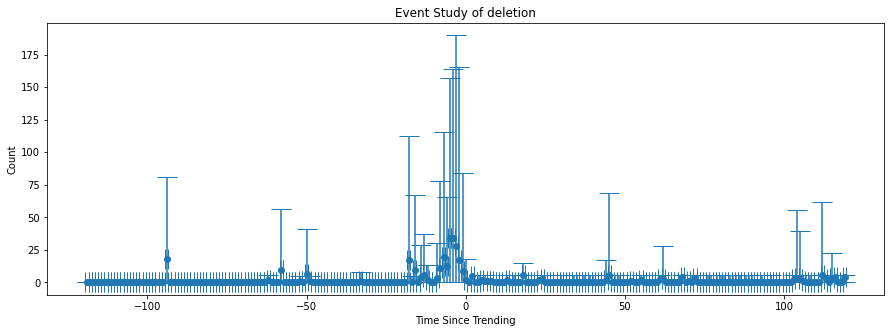

In [316]:
plt.figure(figsize=(15,5))
trending.plot_event_study(panel_df, cat='deletion', lower=-120, upper=120)

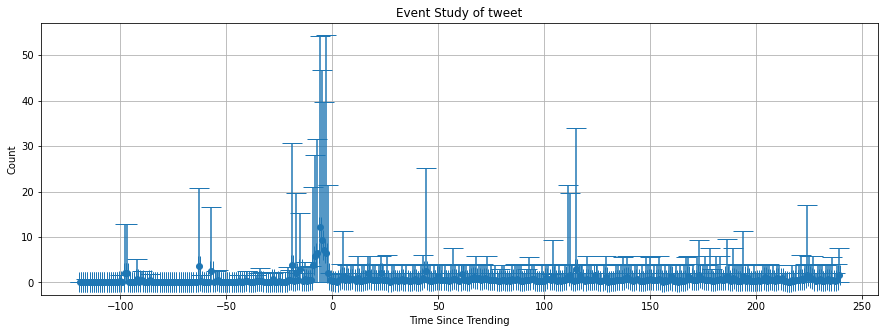

In [317]:
plt.figure(figsize=(15,5))
trending.plot_event_study(panel_df, cat='tweet', lower=-120, upper=240)
plt.grid()

## Statistical Analysis

In [27]:
from statsmodels.formula.api import poisson
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import negativebinomial
query = panel_df.query('time >= -120 & time <= 180').fillna(0)
#query.loc[query.time < 0, 'tweet'] = 0
query.trend = pd.Categorical(query.trend).codes
query = query.dropna()

formula_string = "tweet ~ time*threshold"

query['ln_tweet'] = np.log(query.tweet + 1)

ols = smf.ols(formula_string, data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['trend']})


re = smf.mixedlm(formula_string, data=query, groups=query['trend']).fit()
re_ln = smf.mixedlm('ln_' + formula_string, data=query, groups=query['trend']).fit()

pois = poisson(formula_string, data=query).fit()
negbin = negativebinomial(formula_string, data=query).fit()



Optimization terminated successfully.
         Current function value: 2.560361
         Iterations 7
Optimization terminated successfully.
         Current function value: 1.698223
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27


In [30]:
np.exp(.294)

1.3417839036669714

In [28]:
from statsmodels.iolib.summary2 import summary_col
summary_col([ols, re, re_ln, pois, negbin], 
           model_names=['OLS', 'Random Effects', 'Random Effects (logged outcome)', 'Poisson', 'Negative Binomial'])

,OLS,Random Effects,Random Effects (logged outcome),Poisson,Negative Binomial
Group Var,,0.4697,0.5432,,
,,(0.1039),(0.1195),,
Intercept,1.4663,1.4364,0.5891,0.6465,0.5208
,(0.2768),(0.3237),(0.0872),(0.0709),(0.1458)
R-squared,0.0453,,,,
,0.0466,,,,
alpha,,,,,2.7578
,,,,,(0.1415)
threshold,0.9837,1.0175,0.2945,0.2528,0.3770
,(0.3332),(0.2360),(0.0607),(0.0780),(0.1705)


In [38]:
query.tweet.sum()

4086.0

In [36]:
len(query.trend.unique())

47

Text(0.5, 1.0, 'Turkish Astroturfed Trends Event Study')

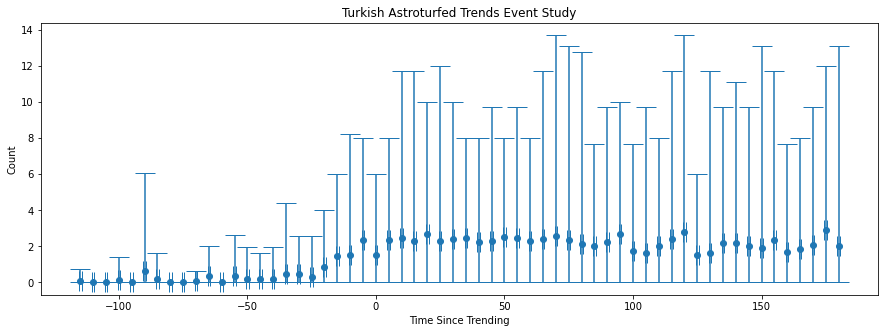

In [34]:
import trending
plt.figure(figsize=(15,5))
trending.plot_event_study(query, cat='tweet', lower=-120, upper=240)
plt.title("Turkish Astroturfed Trends Event Study")

In [80]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tweet   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     17.73
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           8.67e-08
Time:                        12:14:46   Log-Likelihood:                -5437.3
No. Observations:                2137   AIC:                         1.088e+04
Df Residuals:                    2133   BIC:                         1.091e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4663      0.277      5.298      0.000       0.924       2.009
time               0.0156      0.003      5.064      0.000       0.010       0.022
threshold          0.9837      0.333      2.952      0.003       0.331       1.637
time:threshold    -0.0180      0.004     -4.252      0.000      -0.026      -0.010
==============================================================================
Omnibus:                     1281.227   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14722.135
Skew:                           2.655   Prob(JB):                         0.00
Kurtosis:                      14.711   Cond. No.                         716.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [74]:
query = panel_df.query('time >= 0 & time <= 120').fillna(0)
query.trend = pd.Categorical(query.trend).codes
query = query.dropna()

ols = smf.ols("tweet ~ time", data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['trend']})
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tweet   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4765
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.493
Time:                        12:11:53   Log-Likelihood:                -2919.1
No. Observations:                1132   AIC:                             5842.
Df Residuals:                    1130   BIC:                             5852.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4395      0.340      7.180      0.000       1.774       3.105
time          -0.0021      0.003     -0.690      0.490      -0.008       0.004
==============================================================================
Omnibus:                      399.101   Durbin-Watson:                   1.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1198.499
Skew:                           1.794   Prob(JB):                    5.61e-261
Kurtosis:                       6.540   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [47]:
import numpy as np
query = panel_df.query('time >= 0 & time <= 120').fillna(0)
query.trend = pd.Categorical(query.trend).codes
query = query.dropna()
query['ln_tweet'] = np.log(query.tweet+1)
ols = smf.ols("ln_tweet ~ time", data=query).fit(
    cov_type='cluster', cov_kwds={'groups': query['trend']})
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_tweet   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1931
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.662
Time:                        08:38:51   Log-Likelihood:                -1558.6
No. Observations:                1134   AIC:                             3121.
Df Residuals:                    1132   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9111      0.108      8.428      0.000       0.699       1.123
time          -0.0004      0.001     -0.439      0.660      -0.002       0.002
==============================================================================
Omnibus:                       85.240   Durbin-Watson:                   1.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.174
Skew:                           0.741   Prob(JB):                     2.39e-23
Kurtosis:                       2.925   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [217]:
df.created_at.describe()

count                   25366
unique                  11091
top       2019-09-01 05:59:50
freq                       45
Name: created_at, dtype: object

In [214]:
df.date

0        2019-09-01
1        2019-09-01
2        2019-09-01
3        2019-09-01
4        2019-09-01
            ...    
25361    2019-09-01
25362    2019-09-01
25363    2019-09-01
25364    2019-09-01
25365    2019-09-01
Name: date, Length: 25366, dtype: object

# Scratch

In [264]:
df.groupby("trend").size().sort_values(ascending=False).head(40)

trend
#İnşaAllahBinali              13769
İstanbul                      12064
#BYvsEİ                       11023
#KararMilletin                10045
15 Temmuz                      9905
#BugünHerŞeyÇokGüzelOlacak     9210
#LeylayaUmutOl                 8035
Binali Yıldırım                7508
#pazartesi                     7352
#MGMAVOTE                      7267
#cumartesi                     7128
#Pride2019                     6777
#EkrandakiYalancı              6718
#YeniBirBaşlangıç              6703
#SiverektekiKatliamaSesVer     6666
#15TemmuzDestanı               6332
#İstanbulunUmuduİmamoğlu       6147
#15TemmuzGecesi                6041
#herseycokguzeloldu            5916
Öcalan                         5910
#kayyum                        5827
#15TEMMUZDESTANI               5732
#pazar                         5678
#unutMADIMAKlımda              5659
#AilemizHerŞeyimiz             5644
#yks2019                       5555
#izmiryanıyor                  5443
#HayırlıCumalar       

In [77]:

num, den = 0, 0 
sizes = []
for trend, tweets in campaigns.items():
    den += 1
    temp = trending_info[trending_info.keyword == trend]
    if len(temp) > 0:
        sizes.append(len(tweets))
        num += 1

print(num/den)


0.04095112285336856


(array([26.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  1. ,  58.1, 115.2, 172.3, 229.4, 286.5, 343.6, 400.7, 457.8,
        514.9, 572. ]),
 <BarContainer object of 10 artists>)

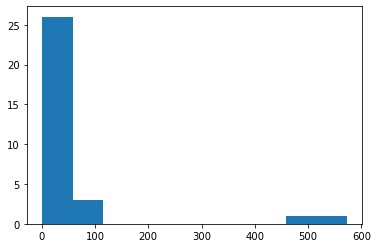

In [79]:
plt.hist(sizes)

In [50]:
df[df.trend == "\"Zilli\""]

,author_id,created_at,date,id,text,trend,trend_date,tweet_type
322,80162128,2019-09-01 01:15:04,2019-09-01,1167969086350872577,"RT @Emniyetci_: Erkek neden ""Delikanlı"" kadın ...","""Zilli""",2019-08-30,retweet


In [93]:
df.tweet_type

0         retweet
1         retweet
2         retweet
3        deletion
4         retweet
           ...   
25361    deletion
25362    deletion
25363    deletion
25364    deletion
25365    deletion
Name: tweet_type, Length: 25366, dtype: object

In [53]:
campaigns = df.groupby("trend").apply(lambda x: x.to_dict(orient="records")).to_dict()

In [55]:
campaigns["#1EylülDünyaBarışGünü"]

[{'author_id': 1012033887084666881,
  'created_at': '2019-09-01 04:14:18',
  'date': '2019-09-01',
  'id': 1168014191887867904,
  'text': 'bugün  #1EylülDünyaBarışGünü  bugün kardeşlik  günü https://t.co/LA2eZID5Wr',
  'trend': '#1EylülDünyaBarışGünü',
  'trend_date': '2019-09-01',
  'tweet_type': 'tweet'},
 {'author_id': 884912305,
  'created_at': '2019-09-01 05:03:59',
  'date': '2019-09-01',
  'id': 1168026695145787392,
  'text': 'RT @sevimari1: Birbirimize sarılalım ki, bu topraklarda çiçekler açsın. #1EylülDünyaBarışGünü 🕊',
  'trend': '#1EylülDünyaBarışGünü',
  'trend_date': '2019-09-01',
  'tweet_type': 'retweet'},
 {'author_id': 4838589401,
  'created_at': '2019-09-01 05:18:11',
  'date': '2019-09-01',
  'id': 1168030268692631553,
  'text': 'RT @evrenselgzt: Sefer Selvi #1EylülDünyaBarışGünü mitinginde kullanılacak bazı sloganların yasaklanmasını çizdi https://t.co/4ZkMUBfQjo https://t.co/S6am4XELF4',
  'trend': '#1EylülDünyaBarışGünü',
  'trend_date': '2019-09-01',
  'tweet_ty

In [58]:
import sys
!{sys.executable} -m pip install emoji

     |████████████████████████████████| 131 kB 8.7 MB/s eta 0:00:01
